In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = "../data"

print("Current working dir:", os.getcwd())
print("DATA_DIR exists:", os.path.exists(DATA_DIR))
print("Files in DATA_DIR:")
for f in sorted(os.listdir(DATA_DIR)):
    print(" -", f)


Current working dir: e:\Computational Intelligence\CIS6005_Kaggle_Project_Folder_Structure\02_notebook
DATA_DIR exists: True
Files in DATA_DIR:
 - IA.tsv
 - Test
 - Train
 - sample_submission.tsv


In [3]:
train_terms = pd.read_csv(f"{DATA_DIR}/Train/train_terms.tsv", sep="\t")
train_terms.columns = ["protein_id", "go_id", "ontology"]

print("train_terms shape:", train_terms.shape)
print("unique proteins:", train_terms["protein_id"].nunique())
print("unique GO terms:", train_terms["go_id"].nunique())
print("\nOntology counts:")
print(train_terms["ontology"].value_counts())

train_terms.head()

train_terms shape: (537027, 3)
unique proteins: 82404
unique GO terms: 26125

Ontology counts:
ontology
P    250805
C    157770
F    128452
Name: count, dtype: int64


,protein_id,go_id,ontology
0,Q5W0B1,GO:0000785,C
1,Q5W0B1,GO:0004842,F
2,Q5W0B1,GO:0051865,P
3,Q5W0B1,GO:0006275,P
4,Q5W0B1,GO:0006513,P


In [7]:
import os

try:
    DATA_DIR
except NameError:
    DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))

def extract_uniprot_accession(token: str) -> str:
    # "sp|O42965|YGMH_SCHPO" -> "O42965"
    if "|" in token:
        parts = token.split("|")
        if len(parts) >= 2:
            return parts[1]
    return token

def read_fasta(path):
    seqs = {}
    current_id = None
    parts = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if current_id is not None:
                    seqs[current_id] = "".join(parts)
                header = line[1:]
                token = header.split()[0]
                current_id = extract_uniprot_accession(token)
                parts = []
            else:
                parts.append(line)
        if current_id is not None:
            seqs[current_id] = "".join(parts)
    return seqs

train_seqs = read_fasta(f"{DATA_DIR}/Train/train_sequences.fasta")
test_seqs  = read_fasta(f"{DATA_DIR}/Test/testsuperset.fasta")

print("Train proteins:", len(train_seqs))
print("Test proteins:", len(test_seqs))
print("Example train id:", list(train_seqs.keys())[0])
print("Example train length:", len(train_seqs[list(train_seqs.keys())[0]]))

Train proteins: 82404
Test proteins: 224309
Example train id: A0A0C5B5G6
Example train length: 16


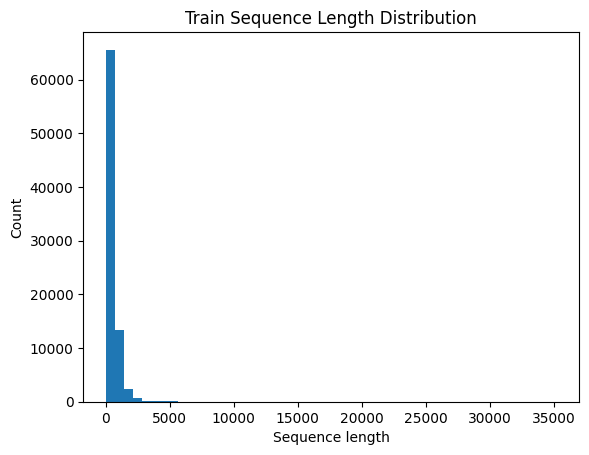

min: 3 max: 35213 mean: 525.79


In [4]:
import numpy as np
import matplotlib.pyplot as plt

train_lengths = [len(s) for s in train_seqs.values()]

plt.figure()
plt.hist(train_lengths, bins=50)
plt.title("Train Sequence Length Distribution")
plt.xlabel("Sequence length")
plt.ylabel("Count")
plt.show()

print("min:", min(train_lengths), "max:", max(train_lengths), "mean:", round(np.mean(train_lengths), 2))


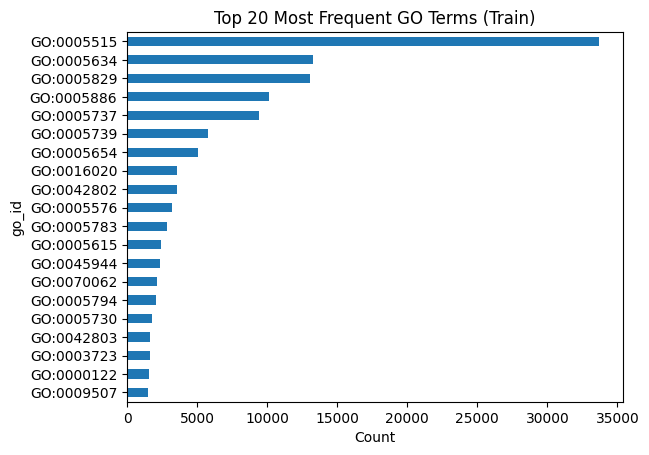

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt

try:
    train_terms
except NameError:
    try:
        DATA_DIR
    except NameError:
        DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
    train_terms = pd.read_csv(f"{DATA_DIR}/Train/train_terms.tsv", sep="\t")
    train_terms.columns = ["protein_id", "go_id", "ontology"]

top_terms = train_terms["go_id"].value_counts().head(20)

plt.figure()
top_terms.sort_values().plot(kind="barh")
plt.title("Top 20 Most Frequent GO Terms (Train)")
plt.xlabel("Count")
plt.show()


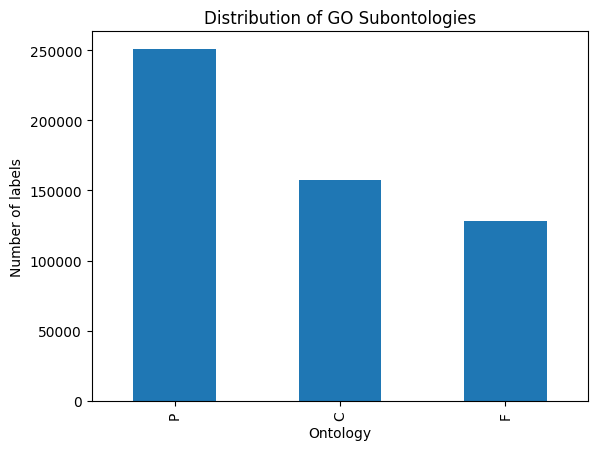

ontology
P    250805
C    157770
F    128452
Name: count, dtype: int64


In [4]:
onto_counts = train_terms["ontology"].value_counts()

plt.figure()
onto_counts.plot(kind="bar")
plt.title("Distribution of GO Subontologies")
plt.xlabel("Ontology")
plt.ylabel("Number of labels")
plt.show()

print(onto_counts)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

def kmers(seq, k=3):
    return " ".join(seq[i:i+k] for i in range(len(seq)-k+1))

def build_rows_for_k(train_seqs, test_seqs, train_terms, k=3, K_NEIGH=5, MAX_TERMS=200, batch_size=30):
    train_ids = list(train_seqs.keys())
    test_ids = list(test_seqs.keys())

    train_text = [kmers(train_seqs[i], k) for i in train_ids]
    test_text  = [kmers(test_seqs[i], k) for i in test_ids]

    print(f"Vectorizing sequences (k={k})...")
    vec = TfidfVectorizer(min_df=2, max_features=100000)
    X_train = vec.fit_transform(train_text)
    X_test  = vec.transform(test_text)

    # Convert to CSR format for faster row slicing
    X_train = X_train.tocsr()
    X_test = X_test.tocsr()

    term_map = train_terms.groupby("protein_id")["go_id"].apply(list).to_dict()

    rows = []
    num_batches = (X_test.shape[0] + batch_size - 1) // batch_size
    
    for start in tqdm(range(0, X_test.shape[0], batch_size), total=num_batches, desc=f"Processing k={k}"):
        end = min(start + batch_size, X_test.shape[0])
        # Use sparse output to avoid expensive dense conversion
        sims = cosine_similarity(X_test[start:end], X_train, dense_output=False).tocsr()

        for i in range(sims.shape[0]):
            pid = test_ids[start + i]
            sim_vec = sims[i].toarray().flatten()
            
            top_idx = np.argsort(sim_vec)[-K_NEIGH:][::-1]
            top_sim = sim_vec[top_idx]

            score_map = {}
            for idx, s in zip(top_idx, top_sim):
                train_pid = train_ids[idx]
                for go in term_map.get(train_pid, []):
                    score_map[go] = max(score_map.get(go, 0), float(s))

            if not score_map:
                continue

            items = sorted(score_map.items(), key=lambda x: x[1], reverse=True)[:MAX_TERMS]
            maxv = items[0][1]
            
            # Avoid division by zero
            if maxv == 0:
                maxv = 1e-10
            
            for go, sc in items:
                prob = sc / maxv
                prob = max(0.001, min(1.0, prob))
                rows.append([pid, go, round(prob, 3)])

    return rows

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

def kmers(seq, k=3):
    return " ".join(seq[i:i+k] for i in range(len(seq)-k+1))

train_ids = list(train_seqs.keys())
test_ids  = list(test_seqs.keys())

train_text_3 = [kmers(train_seqs[i], k=3) for i in train_ids]
test_text_3  = [kmers(test_seqs[i], k=3) for i in test_ids]

vec3 = TfidfVectorizer(min_df=2, max_features=200000)
X_train_3 = vec3.fit_transform(train_text_3)
X_test_3  = vec3.transform(test_text_3)

print("X_train_3:", X_train_3.shape)
print("X_test_3:", X_test_3.shape)


X_train_3: (82404, 8190)
X_test_3: (224309, 8190)


In [9]:
train_term_map = train_terms.groupby("protein_id")["go_id"].apply(list).to_dict()
print("Proteins with labels:", len(train_term_map))


Proteins with labels: 82404


In [15]:
import os, pandas as pd, numpy as np
from sklearn.metrics.pairwise import cosine_similarity

os.makedirs("../05_model/cache_k3", exist_ok=True)

K_NEIGH = 5
MAX_TERMS = 200
BATCH_SIZE = 100  # small

def predict_batch(start, end):
    sims = cosine_similarity(X_test_3[start:end], X_train_3)
    rows = []

    for i, sim_vec in enumerate(sims):
        pid = test_ids[start + i]
        top_idx = np.argsort(sim_vec)[-K_NEIGH:][::-1]
        top_sim = sim_vec[top_idx]

        score_map = {}
        for idx, s in zip(top_idx, top_sim):
            train_pid = train_ids[idx]
            for go in train_term_map.get(train_pid, []):
                score_map[go] = max(score_map.get(go, 0), float(s))

        if not score_map:
            continue

        items = sorted(score_map.items(), key=lambda x: x[1], reverse=True)[:MAX_TERMS]
        maxv = items[0][1]
        
        # Avoid division by zero
        if maxv == 0:
            maxv = 1e-10

        for go, sc in items:
            prob = sc / maxv
            prob = max(0.001, min(1.0, prob))
            rows.append([pid, go, round(prob, 3)])

    return rows

total = X_test_3.shape[0]
print("Total test proteins:", total)
print("Ready to run batches. Example batch: start=0 end=100")


Total test proteins: 224309
Ready to run batches. Example batch: start=0 end=100


In [11]:
start = 0
end = min(start + BATCH_SIZE, X_test_3.shape[0])

rows = predict_batch(start, end)
df = pd.DataFrame(rows, columns=["protein_id", "go_id", "score"])

out_path = f"../05_model/cache_k3/k3_{start}_{end}.parquet"
df.to_parquet(out_path, index=False)

print("Saved batch:", out_path, "rows:", df.shape[0])


Saved batch: ../05_model/cache_k3/k3_0_100.parquet rows: 3771


In [13]:
import glob

files = sorted(glob.glob("../05_model/cache_k3/k3_*.parquet"))
print("Number of batch files:", len(files))

df_all = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)
print("Combined rows:", df_all.shape)

df_all.to_parquet("../05_model/cache/rows_k3.parquet", index=False)
print("Saved final rows_k3.parquet")


Number of batch files: 1
Combined rows: (3771, 3)
Saved final rows_k3.parquet


In [16]:
import os, glob, re
import pandas as pd

# ===== SETTINGS (DO NOT CHANGE if you want identical results) =====
BATCH_SIZE = 100
CACHE_DIR = "../05_model/cache_k3"
os.makedirs(CACHE_DIR, exist_ok=True)

total = X_test_3.shape[0]

# ----- Find next start index from saved files -----
pattern = re.compile(r"k3_(\d+)_(\d+)\.parquet$")

done_ranges = []
for f in glob.glob(os.path.join(CACHE_DIR, "k3_*.parquet")):
    m = pattern.search(f)
    if m:
        s, e = int(m.group(1)), int(m.group(2))
        done_ranges.append((s, e))

done_ranges.sort()

if done_ranges:
    last_s, last_e = done_ranges[-1]
    next_start = last_e
else:
    next_start = 0

print("Total test proteins:", total)
print("Already completed batches:", len(done_ranges))
print("Resuming from index:", next_start)

# ----- Run batches from next_start to end -----
start = next_start
while start < total:
    end = min(start + BATCH_SIZE, total)

    out_path = os.path.join(CACHE_DIR, f"k3_{start}_{end}.parquet")
    if os.path.exists(out_path):
        # Safety: skip if file already exists
        print("Skipping existing batch:", out_path)
        start = end
        continue

    rows = predict_batch(start, end)
    df = pd.DataFrame(rows, columns=["protein_id", "go_id", "score"])
    df.to_parquet(out_path, index=False)

    print(f"Saved batch {start}-{end} | rows: {df.shape[0]} | file: {out_path}")

    # move to next batch
    start = end

print("✅ All batches completed for k=3!")


Total test proteins: 224309
Already completed batches: 1461
Resuming from index: 146100
Saved batch 146100-146200 | rows: 1749 | file: ../05_model/cache_k3\k3_146100_146200.parquet
Saved batch 146200-146300 | rows: 1528 | file: ../05_model/cache_k3\k3_146200_146300.parquet
Saved batch 146300-146400 | rows: 2781 | file: ../05_model/cache_k3\k3_146300_146400.parquet
Saved batch 146400-146500 | rows: 2212 | file: ../05_model/cache_k3\k3_146400_146500.parquet
Saved batch 146500-146600 | rows: 3409 | file: ../05_model/cache_k3\k3_146500_146600.parquet
Saved batch 146600-146700 | rows: 3065 | file: ../05_model/cache_k3\k3_146600_146700.parquet
Saved batch 146700-146800 | rows: 2950 | file: ../05_model/cache_k3\k3_146700_146800.parquet
Saved batch 146800-146900 | rows: 3567 | file: ../05_model/cache_k3\k3_146800_146900.parquet
Saved batch 146900-147000 | rows: 2927 | file: ../05_model/cache_k3\k3_146900_147000.parquet
Saved batch 147000-147100 | rows: 3367 | file: ../05_model/cache_k3\k3_1470

In [17]:
import glob
import pandas as pd

files = sorted(glob.glob("../05_model/cache_k3/k3_*.parquet"))
print("Batch files:", len(files))

df_all = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)
print("Combined rows:", df_all.shape)

os.makedirs("../05_model/cache", exist_ok=True)
df_all.to_parquet("../05_model/cache/rows_k3.parquet", index=False)
print("Saved final: ../05_model/cache/rows_k3.parquet")


Batch files: 2244
Combined rows: (8053315, 3)
Saved final: ../05_model/cache/rows_k3.parquet


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

def kmers(seq, k=4):
    return " ".join(seq[i:i+k] for i in range(len(seq)-k+1))

# IDs (should already exist from earlier)
train_ids = list(train_seqs.keys())
test_ids  = list(test_seqs.keys())

train_text_4 = [kmers(train_seqs[i], k=4) for i in train_ids]
test_text_4  = [kmers(test_seqs[i], k=4) for i in test_ids]

vec4 = TfidfVectorizer(min_df=2, max_features=200000)
X_train_4 = vec4.fit_transform(train_text_4)
X_test_4  = vec4.transform(test_text_4)

print("X_train_4:", X_train_4.shape)
print("X_test_4:", X_test_4.shape)


X_train_4: (82404, 160058)
X_test_4: (224309, 160058)


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

K_NEIGH = 5
MAX_TERMS = 200

def predict_batch_k4(start, end):
    sims = cosine_similarity(X_test_4[start:end], X_train_4)
    rows = []

    for i, sim_vec in enumerate(sims):
        pid = test_ids[start + i]
        top_idx = np.argsort(sim_vec)[-K_NEIGH:][::-1]
        top_sim = sim_vec[top_idx]

        score_map = {}
        for idx, s in zip(top_idx, top_sim):
            train_pid = train_ids[idx]
            for go in train_term_map.get(train_pid, []):
                score_map[go] = max(score_map.get(go, 0), float(s))

        if not score_map:
            continue

        items = sorted(score_map.items(), key=lambda x: x[1], reverse=True)[:MAX_TERMS]
        maxv = items[0][1]

        # Avoid division by zero
        if maxv == 0:
            maxv = 1e-10

        for go, sc in items:
            prob = sc / maxv
            prob = max(0.001, min(1.0, prob))
            rows.append([pid, go, round(prob, 3)])

    return rows

print("k=4 predictor ready.")

k=4 predictor ready.


In [20]:
import os, glob, re
import pandas as pd

BATCH_SIZE = 100
CACHE_DIR = "../05_model/cache_k4"
os.makedirs(CACHE_DIR, exist_ok=True)

total = X_test_4.shape[0]

pattern = re.compile(r"k4_(\d+)_(\d+)\.parquet$")

done_ranges = []
for f in glob.glob(os.path.join(CACHE_DIR, "k4_*.parquet")):
    m = pattern.search(f)
    if m:
        s, e = int(m.group(1)), int(m.group(2))
        done_ranges.append((s, e))

done_ranges.sort()

if done_ranges:
    last_s, last_e = done_ranges[-1]
    next_start = last_e
else:
    next_start = 0

print("Total test proteins:", total)
print("Already completed batches:", len(done_ranges))
print("Resuming from index:", next_start)

start = next_start
while start < total:
    end = min(start + BATCH_SIZE, total)

    out_path = os.path.join(CACHE_DIR, f"k4_{start}_{end}.parquet")
    if os.path.exists(out_path):
        print("Skipping existing batch:", out_path)
        start = end
        continue

    rows = predict_batch_k4(start, end)
    df = pd.DataFrame(rows, columns=["protein_id", "go_id", "score"])
    df.to_parquet(out_path, index=False)

    print(f"Saved batch {start}-{end} | rows: {df.shape[0]} | file: {out_path}")
    start = end

print("✅ All batches completed for k=4!")


Total test proteins: 224309
Already completed batches: 0
Resuming from index: 0
Saved batch 0-100 | rows: 3219 | file: ../05_model/cache_k4\k4_0_100.parquet
Saved batch 100-200 | rows: 3726 | file: ../05_model/cache_k4\k4_100_200.parquet
Saved batch 200-300 | rows: 3338 | file: ../05_model/cache_k4\k4_200_300.parquet
Saved batch 300-400 | rows: 3326 | file: ../05_model/cache_k4\k4_300_400.parquet
Saved batch 400-500 | rows: 4258 | file: ../05_model/cache_k4\k4_400_500.parquet
Saved batch 500-600 | rows: 3616 | file: ../05_model/cache_k4\k4_500_600.parquet
Saved batch 600-700 | rows: 4458 | file: ../05_model/cache_k4\k4_600_700.parquet
Saved batch 700-800 | rows: 3796 | file: ../05_model/cache_k4\k4_700_800.parquet
Saved batch 800-900 | rows: 3779 | file: ../05_model/cache_k4\k4_800_900.parquet
Saved batch 900-1000 | rows: 3406 | file: ../05_model/cache_k4\k4_900_1000.parquet
Saved batch 1000-1100 | rows: 3658 | file: ../05_model/cache_k4\k4_1000_1100.parquet
Saved batch 1100-1200 | row

ZeroDivisionError: division by zero